In [1]:
import numpy as np
import mdtraj as md
import matplotlib.pyplot as plt
import sys

sys.path.append('/Users/thor/surfdrive/Projects/pymdna/studies/1_protein-dna_filament/')
# from numpy import dot
from filament import *
from voxelizer import *

# # Path: pymdna/__init__.py, prototype of the package and atomic is not properly referenced in the package at genertors.py now I just explicitly define the path loction
sys.path.append('/Users/thor/surfdrive/Projects/pymdna/')
import pymdna as mdna 

%load_ext autoreload
%autoreload 2

joblib is not installed. Falling back to sequential computation.


Point [ 2 15 24] is inside voxel space. Moving to nearest zero voxel.
Point [ 2 15 24], 5774 is nearest zero voxel (2, 14, 24), 5724
Point [10 27 20] is inside voxel space. Moving to nearest zero voxel.
Point [10 27 20], 26370 is nearest zero voxel (11, 27, 20), 28870
Point [22 30 29] is inside voxel space. Moving to nearest zero voxel.
Point [22 30 29], 56529 is nearest zero voxel (21, 30, 29), 54029
Point [22 22 25] is inside voxel space. Moving to nearest zero voxel.
Point [22 22 25], 56125 is nearest zero voxel (23, 22, 25), 58625
Point [35 30 19] is inside voxel space. Moving to nearest zero voxel.
Point [35 30 19], 89019 is nearest zero voxel (34, 30, 19), 86519
Point [37 32 26] is inside voxel space. Moving to nearest zero voxel.
Point [37 32 26], 94126 is nearest zero voxel (37, 31, 26), 94076
Point [48 31 28] is inside voxel space. Moving to nearest zero voxel.
Point [48 31 28], 121578 is nearest zero voxel (48, 32, 29), 121629
[ 2 14 24] [11 27 20]
[11 27 20] [21 30 29]
[21 3

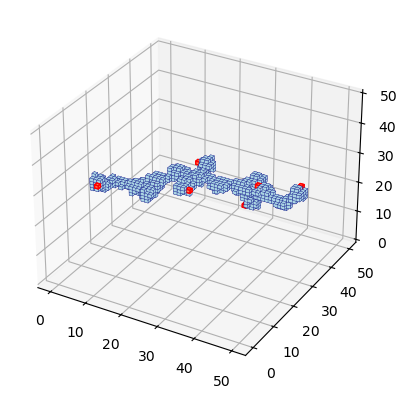

In [2]:
def get_COM_selections(traj, QGR_resids):
    coms = []
    for ids in QGR_resids:
        selection = traj.top.select(f'resid {ids[0]} {ids[1]} {ids[2]}')
        com = md.compute_center_of_mass(traj.atom_slice(selection))
        coms.append(com)
    return np.array([list(l) for l in list(np.array(coms).swapaxes(0,1)[0])])

traj = md.load('./pdbs/0_dimer_4_0.pdb')
xyz = traj.xyz[0]

atom_indices = traj.top.select('resSeq 111 112 113')
QGR = []
for index in atom_indices:
    at = traj.top.atom(index)
    res = at.residue
    QGR.append(res.index)

QGR = np.unique(QGR)
QGR_chunks = np.array([QGR[i:i + 3] for i in range(0, len(QGR), 3)])
QGR_chunks = np.delete(QGR_chunks, 1, 0)
points  = get_COM_selections(traj, QGR_chunks)


V = Voxelizer(xyz,n=50)
V.process_points(points=points)
V.plot(control_points=True)

path = V.find_path(ordered=True,radius=1)
xyz_path = V.voxel_to_xyz(path)

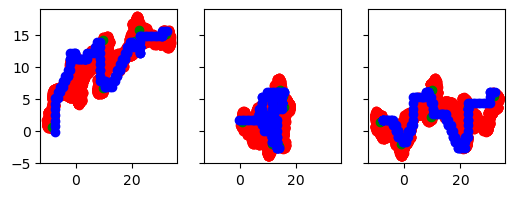

In [3]:
# plot xyz in 3D
fig, ax = plt.subplots(1,3,figsize=[6,2],sharex=True,sharey=True)
ax[0].scatter(xyz[:,0], xyz[:,1], c='r', marker='o')
ax[0].plot(xyz_path[:,0], xyz_path[:,1],c='b', marker='o')
ax[0].scatter(points[:,0], points[:,1], c='g', marker='o')

ax[1].scatter(xyz[:,1], xyz[:,2], c='r', marker='o')
ax[1].plot(xyz_path[:,1], xyz_path[:,2],c='b', marker='o')
ax[1].scatter(points[:,1], points[:,2], c='g', marker='o')

ax[2].scatter(xyz[:,0], xyz[:,2], c='r', marker='o')
ax[2].plot(xyz_path[:,0], xyz_path[:,2],c='b', marker='o')
ax[2].scatter(points[:,0], points[:,2], c='g', marker='o')


# # plot xyz in 3D
# fig = plt.figure()
# ax = fig.add_subplot(111, projection='3d')
# ax.scatter(xyz[:,0], xyz[:,1], xyz[:,2], c='r', marker='o')
# ax.plot(xyz_path[:,0], xyz_path[:,1], xyz_path[:,2], c='b', marker='o')
# ax.scatter(points[:,0], points[:,1], points[:,2], c='g', marker='o')

In [5]:
import numpy as np
from scipy.signal import savgol_filter

# Smooth path a bit 
path_xyz = V.voxel_to_xyz(path)
smooth_path_xyz = savgol_filter(path_xyz, window_length=20, polyorder=3, axis=0)

# Convert the control points to a spline
spline = mdna.SplineFrames(smooth_path_xyz)

# Generate the DNA structure
generator = mdna.StructureGenerator(sequence=None,spline=spline)
dna = generator.get_traj()

mix = traj.stack(dna)
mix.save('0_mix.pdb')

AGATGGCAGACGAGACTGTTGACCCTGGCCCTTCTCTCCAGCAAACCTAAGATCCCCCATCTGATTGCGGGCAGAGTGGATGCAGTACCCCGTTACTTGGACTGAGTTGGTTTCCACCCACAATTGTCTTTCCAAAATTATAGTATTTGTGCCGACGTCAGTGGCATACTCAGGGAGGGACCGTCTCCCTGAAATCTTA


In [6]:
import openmm as mm
import openmm.app as app
import openmm.unit as unit
from mdtraj.reporters import HDF5Reporter

pdb = mix

In [7]:
time = 1 * unit.picoseconds
time_step = 2 * unit.femtoseconds
temperature = 310 * unit.kelvin
steps = int(time/time_step)

name = 'mix'
topology = pdb.topology.to_openmm()
modeller = app.Modeller(topology, pdb.xyz[0])

forcefield = app.ForceField('amber14-all.xml', 'amber14/tip3pfb.xml')
modeller.addHydrogens(forcefield)
modeller.addSolvent(forcefield, padding=1.0*unit.nanometers)

system = forcefield.createSystem(modeller.topology, nonbondedMethod=app.CutoffNonPeriodic)
integrator = mm.LangevinIntegrator(temperature, 1.0/unit.picoseconds, time_step)

simulation = app.Simulation(modeller.topology, system, integrator)
simulation.context.setPositions(modeller.positions)
simulation.reporters.append(HDF5Reporter(f'./{name}'+'.h5', 100))
simulation.reporters.append(app.StateDataReporter(f'./output_{name}.csv', 100, step=True, potentialEnergy=True, temperature=True,speed=True))
simulation.minimizeEnergy()
simulation.step(steps)



500


In [ ]:
simulation.reporters[0].close()
traj = md.load(f'./{name}'+'.h5')